<a href="https://colab.research.google.com/github/SerasLain/ML_2019/blob/master/Copy_of_exam_var2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 8: Why do we use Cross Entropy Loss for training a Language Model?

Обучение лингвистической модели — это задача мультиноминальной классификации, где мы предсказываем, какое слово из словаря окажется на той или иной позиции в последовательности, причем при обучении мы точно знаем, какое именно слово реально встретилось в тексте на этом месте. Кросс-энтропия реальной сиитуации — 0, так как мы знаем правильное слово и точно уверены в том, что оно встретилось именно там, где оно встретилось. Мы хотим получить модель, которая будет уверенно и правильно угадывать слова. Чем хуже модель угадывает слово и чем более уверенно она ошибается, тем больше кросс-энтропия от нуля, поэтому она хорошо работает как функция потерь в задачах языкового моделирования.

# Exam

Develop a model for predicting review rating.  
**Binary classification:**  
**positive class: target = 5**   
**negative class: target = 1,2,3,4**  
Score: **binary F1**  
You are forbidden to use test dataset for any kind of training.  
Remember proper training pipeline.  
If you are not using default params in the models, you have to use some validation scheme to justify them. 

Use `random_state` or `seed` params - your experiment must be reprodusible.


### 1 baseline = 0.720
### 2 baseline = 0.745


In [2]:
!wget https://github.com/thedenaas/hse_seminars/blob/master/2019/exam/exam_data.zip?raw=true

--2020-03-24 12:23:33--  https://github.com/thedenaas/hse_seminars/blob/master/2019/exam/exam_data.zip?raw=true
Resolving github.com (github.com)... 13.229.188.59
Connecting to github.com (github.com)|13.229.188.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/thedenaas/hse_seminars/raw/master/2019/exam/exam_data.zip [following]
--2020-03-24 12:23:34--  https://github.com/thedenaas/hse_seminars/raw/master/2019/exam/exam_data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thedenaas/hse_seminars/master/2019/exam/exam_data.zip [following]
--2020-03-24 12:23:34--  https://raw.githubusercontent.com/thedenaas/hse_seminars/master/2019/exam/exam_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.

In [3]:
!unzip /content/exam_data.zip?raw=true

Archive:  /content/exam_data.zip?raw=true
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
import pandas as pd
import numpy as np

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train['target'] = (df_train['target'] == 5).astype(np.int)
df_test['target'] = (df_test['target'] == 5).astype(np.int)

df_train.shape

(48192, 3)

In [6]:
df_train.head()

,review,title,target
0,"The staff was very friendly, the breakfast ver...",Walker Gem,1
1,Excellent service - very approachable and prof...,Excellent Service,0
2,Really a top notch place to spend a day at the...,"Good location, warm and friendly staff",1
3,"a little noisy, there was a false fire alarm a...","nice hotel,",0
4,Place had too many animals and I'm allergic to...,Experience,0


In [7]:
set(df_train.target)

{0, 1}

In [8]:
set(df_test.target)

{0, 1}

Итого, имеем задачу бинарной классификации текстов.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

np.random_state = 42

In [0]:
x_train, x_validation, y_train, y_validation = train_test_split((df_train.review + ' ' + df_train.title), df_train.target, test_size=0.3)

In [14]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2020-03-24 12:24:56--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz      6%[>                   ]  81.44M  9.80MB/s    eta 2m 23s ^C
gzip: cc.ru.300.vec already exists; do you wish to overwrite (y or n)? ^C


In [0]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
def preprocessing(text):
    """
    :param text: raw text
    :return: list of tokens
    """
    words = wordpunct_tokenize(text.lower())
    return words

In [16]:
preprocessing('На старт внимание… Паника!')

['на', 'старт', 'внимание', '…', 'паника', '!']

In [0]:
from collections import Counter


frequency_dict = Counter()
lengths = []

for rev, title in zip(df_train.review, df_train.title):
    
    words = preprocessing(rev + '.' + title)
    
    lengths.append(len(words))
    
    frequency_dict.update(words)

Я хочу тренировать нейросеть, поэтому нужно понять, какая должна быть максимальная длина последовательности

In [0]:
import seaborn as sns
from matplotlib import pyplot as plt

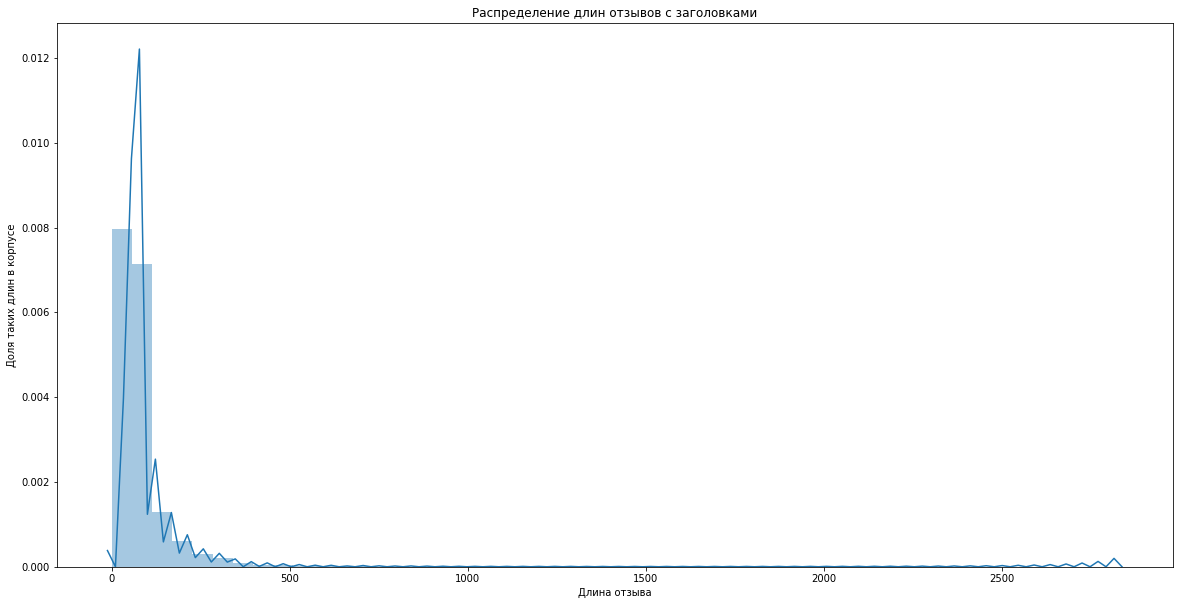

In [19]:
plt.figure(figsize=(20, 10))
plt.title('Распределение длин отзывов с заголовками')
plt.xlabel('Длина отзыва')
plt.ylabel('Доля таких длин в корпусе')
sns.distplot(lengths)

По графику видно, что максимальная длина последовательности может быть ограничена числом 500.

In [20]:
from tqdm import tqdm

index = {'PAD': 0}
vectors = []
    
with open('cc.ru.300.vec') as w2v_f:
    
    n_words, embedding = w2v_f.readline().split()
    n_words, embedding = int(n_words), int(embedding)


    vectors.append(np.zeros((1, embedding)))

    progress_bar = tqdm(desc='Loading word2vec', total=n_words)

    while True:

        line = w2v_f.readline().strip()

        if not line:
            break
        
        current_parts = line.split()

        current_word = ' '.join(current_parts[:-embedding])

        if current_word in frequency_dict:
            
            index[current_word] = len(index)

            current_vectors = current_parts[-embedding:]
            current_vectors = np.array(list(map(float, current_vectors)))
            current_vectors = np.expand_dims(current_vectors, 0)

            vectors.append(current_vectors)

        progress_bar.update(1)

    progress_bar.close()

vectors = np.concatenate(vectors)

Loading word2vec: 100%|██████████| 2000000/2000000 [02:05<00:00, 15982.27it/s]


In [0]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class PreprocDataset(Dataset):
    def __init__(self, x, y, index, max_length=500, pad_token='PAD', verbose=False):
        
        super().__init__()
        
        self.x = []
        self.y = y
        
        self.index = index
        self.max_length = max_length
        
        self.pad_token = pad_token
        self.pad_index = self.index[self.pad_token]
        
        self.load(x, verbose=verbose)
        
    @staticmethod
    def preproc(text):
        words = preprocessing(text)
        return words
        
    def load(self, data, verbose=True):
        
        iterator = tqdm(data, desc='Loading', disable=not verbose)
        
        for text in iterator:
            
            words = self.preproc(text)
            
            indexed_words = self.indexing(words)
            
            self.x.append(indexed_words)
    
    def indexing(self, tokenized_text):
        return [self.index[word] for word in tokenized_text if word in self.index]
    
    def padding(self, sent):
        if len(sent) < self.max_length:
          n_pad = self.max_length - len(sent)
          return sent + [self.pad_index] * n_pad
        else:
          return sent[:self.max_length]
    
    def __len__(self):      
        return len(self.x)
    
    def __getitem__(self, _id):
        
        x = self.x[_id]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        
        y = self.y[_id]
        
        return x, y

In [0]:
train_dataset = PreprocDataset(list(x_train), list(y_train), index, verbose=False)
train_loader = DataLoader(train_dataset, batch_size=100)

validation_dataset = PreprocDataset(list(x_validation), list(y_validation), index)
validation_loader = DataLoader(validation_dataset, batch_size=100)

In [0]:
from math import sqrt

batch_size = 100
seq_size = 500
emb_size = 300

class MyModel(torch.nn.Module):
    def __init__(self, matrix_w, batch_size, seq_size, emb_size): 
        super().__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(torch.Tensor(matrix_w))

        self.LSTM = torch.nn.LSTM(emb_size, batch_size * 4, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
        self.q_proj = torch.nn.Linear(batch_size * 8, batch_size * 4, bias=True)
        self.k_proj = torch.nn.Linear(batch_size * 8, batch_size * 4, bias=True)
        self.v_proj = torch.nn.Linear(batch_size * 8, batch_size * 4, bias=True)

        self.att_soft = torch.nn.Softmax(dim=2)
        
        self.cnn_3gr = torch.nn.Conv1d(batch_size * 4, batch_size * 2, kernel_size=3)
        self.cnn_4gr = torch.nn.Conv1d(batch_size * 4, batch_size * 2, kernel_size=4)
        self.cnn_5gr = torch.nn.Conv1d(batch_size * 4, batch_size * 2, kernel_size=5)

        self.linear_1 = torch.nn.Linear(3*batch_size * 2, batch_size * 4, bias=True)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(batch_size * 4, out_features=2, bias=True) 

        
    def forward(self, x):
      x_emb = self.embedding(x)
      x, _ = self.LSTM(x_emb)

      x_q = self.q_proj(x)
      x_k = self.k_proj(x)
      x_v = self.v_proj(x)
    
      x_k_T = x_k.transpose(2,1)

      att_scores = torch.bmm(x_q, x_k_T) / sqrt(emb_size)
     
      att_dist = self.att_soft(att_scores)

      attention_vectors = torch.bmm(att_dist, x_v)

      x_att = attention_vectors.transpose(2,1)
      x_cnn3 = self.cnn_3gr(x_att)

      x_cnn4 = self.cnn_4gr(x_att)
      x_cnn5 = self.cnn_5gr(x_att)

      frst, _ =  x_cnn3.max(dim= -1,)
      sc, _ = x_cnn4.max(dim= -1,)
      thr, _ = x_cnn5.max(dim= -1,)
      
      x_cat = torch.cat((frst, sc, thr), dim=-1)
      
      x =  self.linear_1(x_cat)
      x = self.relu(x)    
      x = self.linear_2(x)
    
      return x

In [0]:
model = MyModel(vectors, batch_size, seq_size, emb_size)

In [27]:
vectors.shape

(15500, 300)

In [0]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [29]:
epochs = 5
losses = []
best_test_loss = 10.

test_f1 = []

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_targets = []
    test_pred_class = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    model.train()
    
    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    model.eval()
    
    for x, y in validation_loader:
        
        x = x.to(device)

        with torch.no_grad():

            pred = model(x)

            pred = pred.cpu()

            test_targets.append(y.numpy())
            test_pred_class.append(np.argmax(pred, axis=1))

            loss = criterion(pred, y)

            test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)

    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()

    f1 = f1_score(test_targets, test_pred_class)

    test_f1.append(f1)
    
    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    print('F1 validation - {:.3f}'.format(f1))
        
    # Early stopping:
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 2:   0%|          | 0/33734 [00:00<?, ?it/s]


Losses: train - 0.629, test - 0.532
F1 validation - 0.711


Epoch 3:   0%|          | 0/33734 [00:00<?, ?it/s]


Losses: train - 0.513, test - 0.492
F1 validation - 0.720


Epoch 4:   0%|          | 0/33734 [00:00<?, ?it/s]


Losses: train - 0.485, test - 0.481
F1 validation - 0.730


Epoch 5:   0%|          | 0/33734 [00:00<?, ?it/s]


Losses: train - 0.462, test - 0.470
F1 validation - 0.734


Epoch 5:   1%|▏         | 500/33734 [00:05<05:57, 93.07it/s, train_loss=0.466]

KeyboardInterrupt: ignored

In [33]:
x_test = df_test.review + ' ' + df_test.title
y_test = df_test.target
test_dataset = PreprocDataset(list(x_test), list(y_test), index, verbose=False)

test_loader = DataLoader(test_dataset, batch_size=100)
test_losses = []
for x, y in test_loader:
        
        x = x.to(device)
        
        with torch.no_grad():

            pred = model(x)

            pred = pred.cpu()

            test_targets.append(y.numpy())
            test_pred_class.append(np.argmax(pred, axis=1))

            loss = criterion(pred, y)

            test_losses.append(loss.item())
mean_test_loss = np.mean(test_losses)
test_targets = np.concatenate(test_targets).squeeze()
test_pred_class = np.concatenate(test_pred_class).squeeze()

f1 = f1_score(test_targets, test_pred_class)

test_f1.append(f1)
    
print()
print('Loss: test - {:.3f}'.format(mean_test_loss))

print('F1 validation - {:.3f}'.format(f1))



Loss: test - 0.462
F1 validation - 0.737


In [0]:
len(test_dataset.x)